In [13]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split, KFold
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.framework import arg_scope
from tensorflow.contrib.layers import dropout
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def random_permutation(X,y):
    idx = np.random.permutation(X.shape[0])
    return X[idx], y[idx]

In [15]:
mnist = fetch_mldata('MNIST original')
mnist_X = mnist.data/255 #normalized
mnist_y = mnist.target

mnist_59_X = []
mnist_59_y = []

for i in range(mnist_X.shape[0]):
    if mnist_y[i] >= 5: #filtering out digits from 5 to 9 inclusively
        mnist_59_X.append(mnist_X[i])
        mnist_59_y.append(mnist_y[i])
    
mnist_59_X = np.array(mnist_59_X)
mnist_59_y = np.array(mnist_59_y)

mnist_59_X, mnist_59_y = random_permutation(mnist_59_X, mnist_59_y)

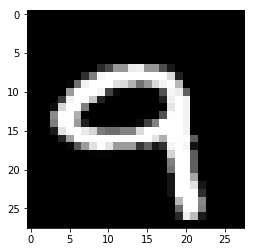

In [16]:
plt.imshow(mnist_59_X[9045,:].reshape(28,28), cmap='gray')

In [17]:
flag_5, count_5 = False, 0
flag_6, count_6 = False, 0
flag_7, count_7 = False, 0
flag_8, count_8 = False, 0
flag_9, count_9 = False, 0


small_dataset_X = []
small_dataset_y = []

size = 170


for i in range(mnist_59_X.shape[0]):
    
    label = mnist_59_y[i]
    
    if label == 5 and flag_5 == False:
        small_dataset_X.append(mnist_59_X[i,:])
        small_dataset_y.append(mnist_59_y[i])
        count_5 += 1
    if label == 6 and flag_6 == False:
        small_dataset_X.append(mnist_59_X[i,:])
        small_dataset_y.append(mnist_59_y[i])
        count_6 += 1
    if label == 7 and flag_7 == False:
        small_dataset_X.append(mnist_59_X[i,:])
        small_dataset_y.append(mnist_59_y[i])
        count_7 += 1
    if label == 8 and flag_8 == False:
        small_dataset_X.append(mnist_59_X[i,:])
        small_dataset_y.append(mnist_59_y[i])
        count_8 += 1
    if label == 9 and flag_9 == False:
        small_dataset_X.append(mnist_59_X[i,:])
        small_dataset_y.append(mnist_59_y[i])
        count_9 += 1
        
    if count_5 >= size:
        flag_5 = True
    if count_6 >= size:
        flag_6 = True
    if count_7 >= size:
        flag_7 = True
    if count_8 >= size:
        flag_8 = True
    if count_9 >= size:
        flag_9 = True
        
small_dataset_X = np.array(small_dataset_X)
small_dataset_y = np.array(small_dataset_y) - 5 #so that targets are from 0 to 4

In [18]:
np.array(small_dataset_X).shape 

(850, 784)

In [19]:
from datetime import datetime

def logdir_generate(mode):
    root_logdir = "tf_logs_transferlearning"
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "{}/{}/run-{}/".format(root_logdir, mode, now)
    
    return logdir

In [20]:
def random_batch(X, y, batch_size):
    
    idx = np.random.randint(0, X.shape[0], batch_size)
    batch_X = X[idx]
    batch_y = y[idx]
    
    return batch_X, batch_y

In [21]:
train_X, test_X, train_y, test_y = train_test_split(small_dataset_X, small_dataset_y, test_size=0.2, shuffle=True, 
                                                    stratify=small_dataset_y)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.25, shuffle=True, 
                                                  stratify=train_y)

In [24]:
train_X.shape

(510, 784)

In [25]:
np.unique(test_y, return_counts=True) #stratified datasets

(array([ 0.,  1.,  2.,  3.,  4.]), array([34, 34, 34, 34, 34], dtype=int64))

In [72]:
n = small_dataset_X.shape[1] #num of features
n_classes = 5 #number of classes to predict
num_neurons = 100 #num of neurons in each hidden layer
learning_rate = 0.0035
n_epochs = 2000
batch_size = 16
keep_prob = 0.7
max_no_winner = 8000 #if no validation loss improvement within max_no_winner steps, stop learning

In [75]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n), name='X')
y = tf.placeholder(tf.int64, shape=(None), name='y')
is_training = tf.placeholder(tf.bool, shape=(), name="is_training")

bn_params = {
    'is_training': is_training,
    'decay': 0.99,
    'updates_collections': None,
    'scale': True
}

with tf.name_scope('DNN'):
    with arg_scope([fully_connected], activation_fn=tf.nn.elu, 
                   weights_initializer=tf.contrib.layers.xavier_initializer(),
                   normalizer_fn=tf.contrib.layers.batch_norm,
                   normalizer_params=bn_params):
        X_drop = dropout(X, keep_prob, is_training=is_training)
        
        hidden1 = fully_connected(X_drop, num_neurons, scope="hidden1")
        hidden1_drop = dropout(hidden1, keep_prob, is_training=is_training)
        
        hidden2 = fully_connected(hidden1_drop, num_neurons, scope="hidden2")
        hidden2_drop = dropout(hidden2, keep_prob, is_training=is_training)
        
        hidden3 = fully_connected(hidden2_drop, num_neurons, scope="hidden3")
        hidden3_drop = dropout(hidden3, keep_prob, is_training=is_training)
        
        hidden4 = fully_connected(hidden3_drop, num_neurons, scope="hidden4")
        hidden4_drop = dropout(hidden4, keep_prob, is_training=is_training)
        
        hidden5 = fully_connected(hidden4_drop, num_neurons, scope="hidden5")
        hidden5_drop = dropout(hidden5, keep_prob, is_training=is_training)
        
        logits = fully_connected(hidden5_drop, n_classes, activation_fn=None, scope="outputs")

with tf.name_scope('loss'):
    xentrophy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentrophy, name='loss')

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[12345]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

#exporting useful values to Tensorboard
loss_summary = tf.summary.scalar("loss", loss)
accuracy_summary = tf.summary.scalar("accuracy", accuracy)
file_writer_train = tf.summary.FileWriter(logdir_generate("train"), tf.get_default_graph())
file_writer_test = tf.summary.FileWriter(logdir_generate("test"), tf.get_default_graph())

init = tf.global_variables_initializer()

reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[12345]")
reuse_vars_dict = [var for var in reuse_vars]
original_saver = tf.train.Saver(reuse_vars_dict)

#creating a saver to save our model
saver = tf.train.Saver()

In [76]:
step = 0
no_winner = 0
stop_learning = False
a = 0

with tf.Session() as sess:
    n_batches = int(np.ceil(train_X.shape[0] / batch_size))
    
    print("STARTING TO TRAIN A NEW MODEL!")
    
    sess.run(init)

    original_saver.restore(sess,"tmp/winner_model")
    
    #getting initial losses and accuracies
    summary_loss_train = loss_summary.eval(feed_dict={is_training: False, X: train_X, y: train_y})
    summary_loss_test = loss_summary.eval(feed_dict={is_training: False, X: val_X, y: val_y})
    summary_accuracy_train = accuracy_summary.eval(feed_dict={is_training: False, X: train_X, y: train_y})
    summary_accuracy_val = accuracy_summary.eval(feed_dict={is_training: False, X: val_X, y: val_y})
    file_writer_train.add_summary(summary_loss_train, 0)
    file_writer_train.add_summary(summary_accuracy_train, 0)
    file_writer_test.add_summary(summary_loss_test, 0)
    file_writer_test.add_summary(summary_accuracy_val, 0)
    
    #early stopping, initializing winner
    winner = loss.eval(feed_dict={is_training: False, X: val_X, y: val_y})

    for epoch in range(n_epochs):
        
        for i in range(n_batches):
            batch_X, batch_y = random_batch(train_X, train_y, batch_size)
            sess.run(training_op, feed_dict={is_training: True, X: batch_X, y: batch_y})
            step += 1
            
            #early stopping
            if step % 100 == 0:
                loss_val = loss.eval(feed_dict={is_training: False, X: val_X, y: val_y})
                if winner > loss_val:
                    winner = loss_val
                    a = step
                    no_winner = 0
                    save_path = saver.save(sess, "tmp_transfer/winner_model")
                else:
                    no_winner += 100
                if max_no_winner < no_winner:
                    stop_learning = True
                    break
            #-----------------
        if stop_learning: #if there was early stopping
            break

        if epoch % 1 == 0:
            summary_loss_train = loss_summary.eval(feed_dict={is_training: False, is_training: False, X: batch_X, y: batch_y})
            summary_loss_test = loss_summary.eval(feed_dict={is_training: False, X: test_X, y: test_y})
            summary_accuracy_train = accuracy_summary.eval(feed_dict={is_training: False, X: train_X, y: train_y})
            summary_accuracy_val = accuracy_summary.eval(feed_dict={is_training: False, X: val_X, y: val_y})
            file_writer_train.add_summary(summary_loss_train, step)
            file_writer_train.add_summary(summary_accuracy_train, step)
            file_writer_test.add_summary(summary_loss_test, step)
            file_writer_test.add_summary(summary_accuracy_val, step)
            
        if epoch % 10 == 0:
            save_path = saver.save(sess, "tmp_transfer/my_model")

    tr_acc = accuracy.eval(feed_dict={is_training: False, X: train_X, y: train_y})
    val_acc = accuracy.eval(feed_dict={is_training: False, X: val_X, y: val_y})
    
print("------------------")
print("End of training!")
print("------------------")
print("Training accuracy:",tr_acc)
print("Validation accuracy:",val_acc)

STARTING TO TRAIN A NEW MODEL!
INFO:tensorflow:Restoring parameters from tmp/winner_model
------------------
End of training!
------------------
Training accuracy: 1.0
Validation accuracy: 0.964706


In [78]:
with tf.Session() as sess:
    saver.restore(sess, "tmp_transfer/winner_model")
    acc = accuracy.eval(feed_dict={is_training: False, X: val_X, y: val_y})
    logit = logits.eval(feed_dict={is_training: False, X: val_X, y: val_y})

INFO:tensorflow:Restoring parameters from tmp_transfer/winner_model


In [79]:
acc

0.97058821

In [55]:
epoch

893

97% val acc without transfer learning

In [50]:
reuse_vars

[<tf.Variable 'hidden1/weights:0' shape=(784, 100) dtype=float32_ref>,
 <tf.Variable 'hidden1/BatchNorm/beta:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden1/BatchNorm/gamma:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden2/weights:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'hidden2/BatchNorm/beta:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden2/BatchNorm/gamma:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden3/weights:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'hidden3/BatchNorm/beta:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden3/BatchNorm/gamma:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden4/weights:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'hidden4/BatchNorm/beta:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden4/BatchNorm/gamma:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden5/weights:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'hidden5/BatchNorm/beta:0' shape=(1

In [49]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'hidden1/weights:0' shape=(784, 100) dtype=float32_ref>,
 <tf.Variable 'hidden1/BatchNorm/beta:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden1/BatchNorm/gamma:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden2/weights:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'hidden2/BatchNorm/beta:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden2/BatchNorm/gamma:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden3/weights:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'hidden3/BatchNorm/beta:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden3/BatchNorm/gamma:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden4/weights:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'hidden4/BatchNorm/beta:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden4/BatchNorm/gamma:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'hidden5/weights:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'hidden5/BatchNorm/beta:0' shape=(1